This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Hybrid indexing

In this tutorial, we combine Hough indexing (HI), dictionary indexing (DI), and refinement in a hybrid indexing approach.
HI is generally much faster than DI, but less robust towards noisy patterns.
To make good use of both indexing approaches, we can index all patterns with HI, identify badly indexed map points, and re-index these with DI.
Before combining orientations obtained from HI and DI into a single map, we must refine them.
As always, it is important to validate intermediate results after each step by inspecting quality metrics, geometrical simulations etc.

We demonstrate this workflow with an EBSD dataset from a single-phase recrystallized nickel sample.
The dataset is available in a repository on Zenodo at <cite data-cite="aanes2019electron">Ånes et al. (2019)</cite>.
The dataset is number ten (24 dB) out of a series of ten datasets in the repostiroy, taken with increasing gain (0-24 dB).
It is *very* noisy, so we will average each pattern with its nearest neighbours before indexing.

The complete workflow is:

1. Load, process, and inspect the full dataset
2. Calibrate geometry to obtain a plane of projection centers (one for each map point)
3. Hough indexing of all patterns
4. Identify (bad) points for re-indexing
5. Re-indexing with dictionary indexing
6. Refine Hough indexed and dictionary indexed points
7. Merge results
8. Validate results

Let's start by important the necessary libraries

In [1]:
# Exchange inline for notebook or qt5 (from pyqt) for interactive plotting
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
import kikuchipy as kp
from orix import plot, sampling
from orix.crystal_map import PhaseList
from orix.vector import Vector3d


plt.rcParams.update(
    {
        "figure.facecolor": "w",
        "font.size": 15,
        "figure.dpi": 75,
    }
)

## Load, process and inspect data

In [2]:
s = kp.data.ni_gain(10, allow_download=True)  # ~100 MB into memory
s

<EBSD, title: Pattern, dimensions: (200, 149|60, 60)>

Enhance the Kikuchi pattern with background correction

In [3]:
s.remove_static_background()
s.remove_dynamic_background()

[########################################] | 100% Completed | 313.01 ms
[########################################] | 100% Completed | 1.24 ss


Average each pattern to its eight nearest neighbors in a Gaussian kernel with a standard deviation of 1

In [4]:
window = kp.filters.Window("gaussian", std=1)
s.average_neighbour_patterns(window)

[########################################] | 100% Completed | 317.74 ms


Inspect an image quality map (pattern sharpness, not to be confused with image/pattern quality determined from the height of peaks in the Radon transform)

In [5]:
maps_iq = s.get_image_quality()

[########################################] | 100% Completed | 728.98 ms


Inspect patterns in the image quality map

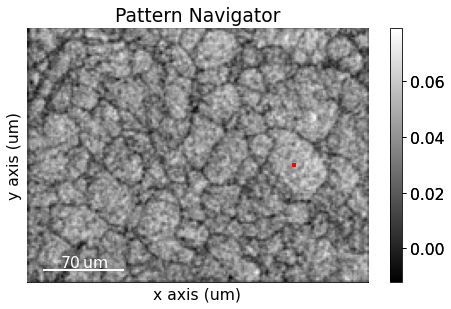

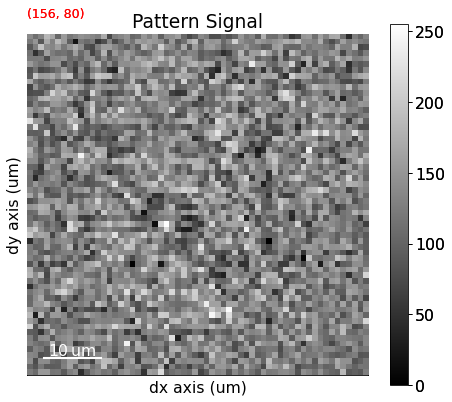

In [6]:
# Move the pointer programmatically to the center of a large grain
s.axes_manager.indices = (156, 80)

s.plot(hs.signals.Signal2D(maps_iq))

The image quality map is *very* noisy.
However, we might be able to convince ourselves that the darker lines are grain boundaries.
The map is noisy because the patterns are noisy.
The pattern shown is from the center of a large grain on the right side of the map from the small red square (the pointer).
Even though the material is well recrystallized with appreciably large grains, the pattern is *very* noisy.
But again, we might be able to convince ourselves that the pattern shows "correlated noise", e.g. a couple of zones axes (darker regions in the pattern) and some bands delineated by darker lines on each side of the band.

## Calibrate geometry

Seven calibration patterns of high quality was acquired prior to acquiring the full dataset above.
These were acquired to calibrate the sample-detector geometry.
The detector was mounted with the screen normal at 0$^{\circ}$ to the horizontal.
The sample was tilted to 70$^{\circ}$ from the horizontal.
We assume these tilts to be correct.
What remains is to determine a plane of projection centers (PCs), one for each map point.
Since we know the detector pixel size (~70 μm on the NORDIF UF-1100 detector), we can extrapolate this plane of PCs from a mean PC.
The workflow is as follows:

1. Estimate PCs from an initial guess using Hough indexing
2. Hough indexing of calibration patterns using estimated PCs
3. Refine Hough indexed orientations and estimated PCs using pattern matching
4. Extrapolate plane of PCs from mean of refined PCs

We validate the results after each step.

Load calibration patterns

In [7]:
s_cal = kp.data.ni_gain_calibration(10)
s_cal

<EBSD, title: Calibration patterns, dimensions: (7|480, 480)>

Remove static and dynamic background

<div class="alert alert-info">

Note

Trial-and-error showed that the dataset of patterns previously loaded, `s`, were better indexed after *subtracting* the static and dynamic background rather than *dividing* by them (the image/pattern quality maps also show a more meaningful contrast).
No clear difference in indexing results are observed for the calibration patterns.
See the tutorial on [pattern processing](pattern_processing.ipynb) for more details.

</div>


In [8]:
s_cal.remove_static_background("divide")
s_cal.remove_dynamic_background("divide")

[########################################] | 100% Completed | 105.60 ms
[########################################] | 100% Completed | 105.72 ms


Extract the positions of the calibration patterns (possibly outside the region of interest [ROI]) and the shape and position of the ROI relative to the area imaged in an overview secondary electron image.
This information is read with the calibration patterns from the NORDIF settings file.

In [9]:
omd = s_cal.original_metadata

Plot calibration pattern map locations

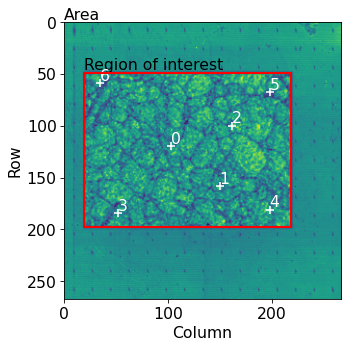

In [10]:
kp.draw.plot_pattern_positions_in_map(
    rc=omd.calibration_patterns.indices_scaled,
    roi_shape=omd.roi.shape_scaled,
    roi_origin=omd.roi.origin_scaled,
    roi_image=maps_iq,
    area_shape=omd.area.shape_scaled,
    area_image=omd.area_image,
    color="w",
)

Hough indexing requires a phase list in order to make a look-up table of interplanar angles to compare the detected angles to (from combinations of bands).
See the [Hough indexing tutorial](hough_indexing.ipynb) for more details.
Since we later on need a dynamically simulated master pattern of nickel (simulated with EMsoft), we will load this here and use the phase description of the master pattern in the phase list.

<div class="alert alert-info">

Note

PyEBSDIndex is an optional dependency of kikuchipy, and can be installed with both `pip` and `conda` (from `conda-forge`).
To install PyEBSDIndex, see their [installation instructions](https://pyebsdindex.readthedocs.io/en/latest/user/installation.html).

</div>


In [11]:
# kikuchipy.data.nickel_ebsd_master_pattern_small() is a lower-resolution alternative
mp = kp.data.ebsd_master_pattern(
    "ni", projection="lambert", energy=20, allow_download=True
)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv, dimensions: (|1001, 1001)>

In [12]:
phase = mp.phase
phase

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

Create a PyEBSDIndex indexer to use with Hough indexing.
We should pass our own reflector list to the indexer, so we generate a set of high-symmetry reflectors $\mathbf{g}$ (see the [tutorial on geometrical simulations](geometrical_ebsd_simulations.ipynb) for details)

In [13]:
g = ReciprocalLatticeVector.from_min_dspacing(phase.deepcopy(), 0.07)
g.sanitise_phase()  # "Fill atoms in unit cell", required for structure factor
g.calculate_structure_factor()
F = abs(g.structure_factor)
g = g[F > 0.12 * F.max()]
g.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    0.203     0.4      0.2      100.0      8   
 2 0 0    0.176     0.3      0.1       60.9      6   
 2 2 0    0.125     0.1      0.0       8.7       12  
 3 1 1    0.106     0.1      0.0       2.0       24  


We get the indexer from the detector attached to the calibration pattern signal

In [14]:
det_cal = s_cal.detector
phase_list = PhaseList(phase)
indexer = det_cal.get_indexer(phase_list, g.unique(True))

Estimate PCs from an initial guess (based on previous experiments) and print the mean and standard deviation

In [15]:
det_cal = s_cal.hough_indexing_optimize_pc(
    pc0=[0.42, 0.22, 0.50],
    indexer=indexer,
    batch=True,
)

print(det_cal.pc_flattened.mean(axis=0))
print(det_cal.pc_flattened.std(0))

[0.41835389 0.22080713 0.5048758 ]
[0.00517155 0.00696523 0.00499261]


Compare the distribution of PCs to the above plotted map locations (especially PCx vs. PCy)

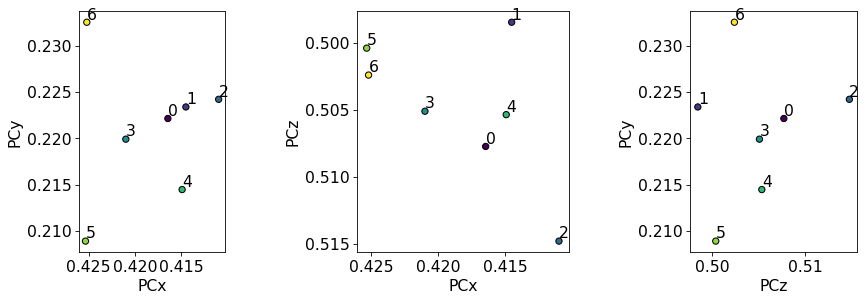

In [16]:
det_cal.plot_pc("scatter", annotate=True)

We see no direct correlation between the sample positions and the PCs.
Let's index the calibration patterns using these PCs and compare the solutions' band positions to the actual bands.
We update our indexer instance with the estimated PCs.

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker, mean): (0.4184, 0.2208, 0.5049)
  Indexing 7 pattern(s) in 1 chunk(s)
Radon Time: 0.011457832995802164
Convolution Time: 0.019633042044006288
Peak ID Time: 0.021466290927492082
Band Label Time: 0.01911912497598678
Total Band Find Time: 0.07191108295228332
Band Vote Time:  0.004455958027392626
  Indexing speed: 79.70217 patterns/s


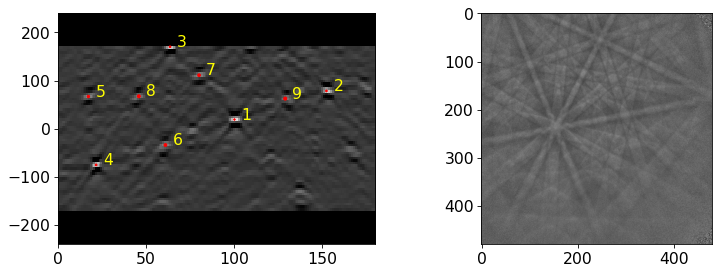

In [17]:
indexer.PC = det_cal.pc
xmap_cal = s_cal.hough_indexing(
    phase_list=phase_list, indexer=indexer, verbose=2
)

Check indexed orientations by plotting geometrical simulations on top of the patterns

In [18]:
simulator = kp.simulations.KikuchiPatternSimulator(g)
sim_cal = simulator.on_detector(det_cal, xmap_cal.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 103.42 ms
Finding zone axes that are in some pattern:
[                                        ] | 0% Completed | 87.54 us

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[########################################] | 100% Completed | 106.02 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 106.89 ms


[########################################] | 100% Completed | 103.77 ms


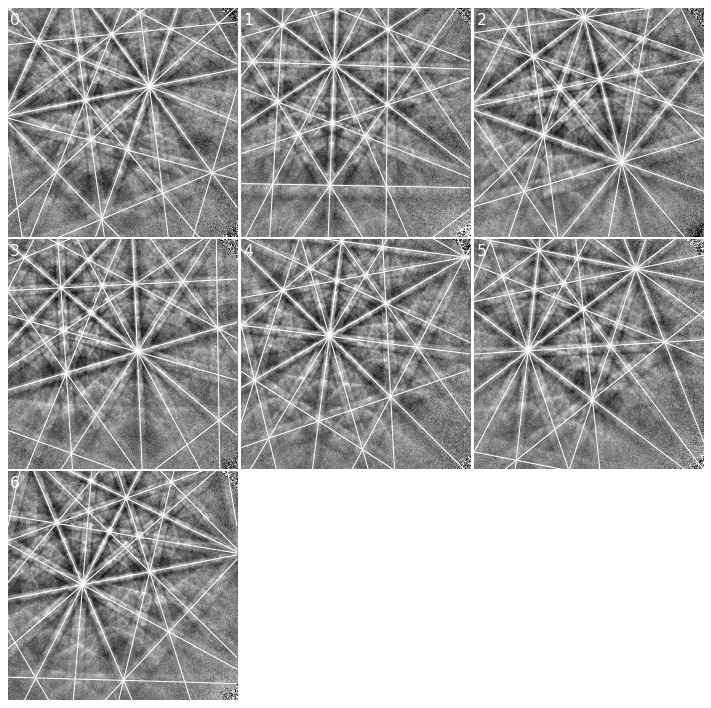

In [19]:
# Enhance meaningful contrast for visualization
s_cal2 = s_cal.normalize_intensity(dtype_out="float32", inplace=False)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
axes = axes.ravel()
for i in range(xmap_cal.size):
    axes[i].imshow(s_cal2.inav[i].data, cmap="gray", vmin=-3, vmax=3)
    lines = sim_cal.as_collections(i, lines_kwargs={"color": "w"})[0]
    axes[i].add_collection(lines)
    axes[i].text(5, 10, i, c="w", va="top", ha="left")
_ = [ax.axis("off") for ax in axes]
fig.subplots_adjust(wspace=0.01, hspace=0.01)

Most lines align quite well with the bands.
Some of them, especially in the lower part of the patterns and on wide bands, do not follow the band center, though (see e.g. pattern 4).
Let's refine these solutions using dynamical simulations

In [20]:
xmap_cal_ref, det_cal_ref = s_cal.refine_orientation_projection_center(
    xmap=xmap_cal,
    detector=det_cal,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5, 0.05, 0.05, 0.05],  # Sufficiently wide
    rtol=1e-5,
    # One pattern per iteration to utilize all CPUs
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5.   5.   5.   0.05 0.05 0.05]
  Relative tolerance: 1e-05
Refining 7 orientation(s) and projection center(s):
[########################################] | 100% Completed | 8.41 sms
Refinement speed: 0.83220 patterns/s


Check quality metrics

In [21]:
print(xmap_cal_ref.scores.mean())
print(xmap_cal_ref.num_evals.mean())

0.4632929904120309
289.2857142857143


Check deviations from Hough indexed solutions (it is important that these deviations are within our trust region above)

In [22]:
angles_cal = xmap_cal.orientations.angle_with(
    xmap_cal_ref.orientations, degrees=True
)
pc_dev_cal = det_cal.pc_flattened - det_cal_ref.pc_flattened

print(angles_cal)
print(abs(pc_dev_cal).max(0))

[1.36443964 1.44295241 1.89755234 1.27138766 0.7285069  1.00574023
 1.76676206]
[0.00865271 0.01459083 0.01570715]


Get geometrical simulations from refined orientations and PCs and add lines from these simulations (in red) to the existing figure

In [23]:
sim_cal_ref = simulator.on_detector(det_cal_ref, xmap_cal_ref.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 105.67 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 106.28 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 106.94 ms


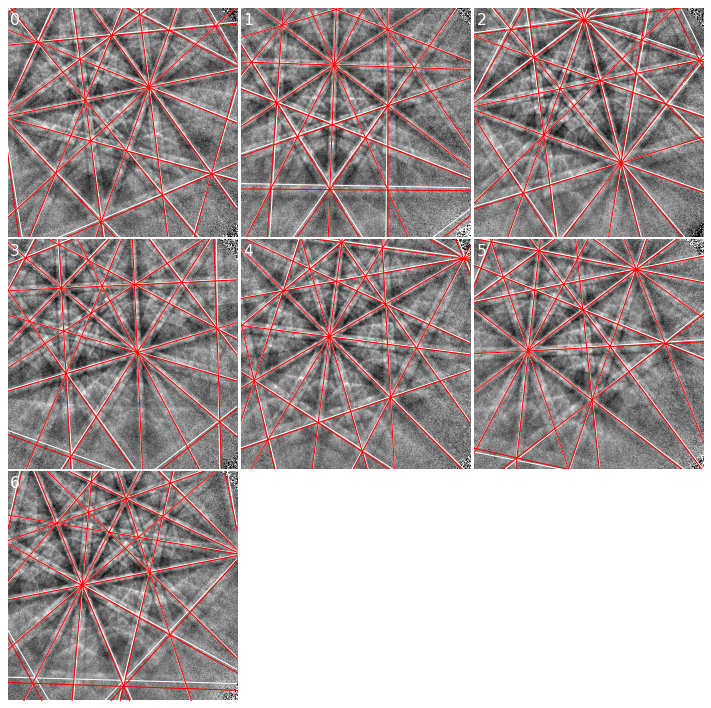

In [24]:
for i in range(xmap_cal_ref.size):
    lines = sim_cal_ref.as_collections(i)[0]
    axes[i].add_collection(lines)
fig

We see that the red lines align better with wider bands and bands in the lower part of the patterns (where the deviations are greater).

Check the refined PCs

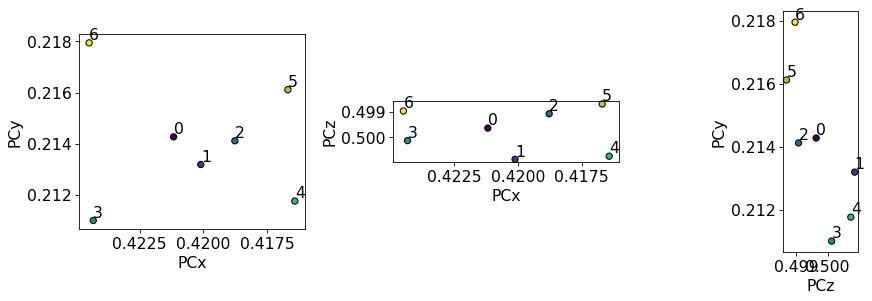

In [25]:
det_cal_ref.plot_pc("scatter", annotate=True)

We now see that the patterns align quite well compared to the sample positions.
We will therefore attempt to fit a plane to these PCs using an affine transformation (see the tutorial on [PC plane fitting](pc_fit_plane.ipynb) for more details).
Note that if the PCs hadn't aligned as nicely as here, we should instead extrapolate a plane of PCs from an average; this procedure is detailed in [another tutorial](pc_extrapolate_plane.ipynb).

[0.42075511 0.21415109 0.4997047 ]
71.24275097953975
[0.00032085 0.00052396 0.00028483]


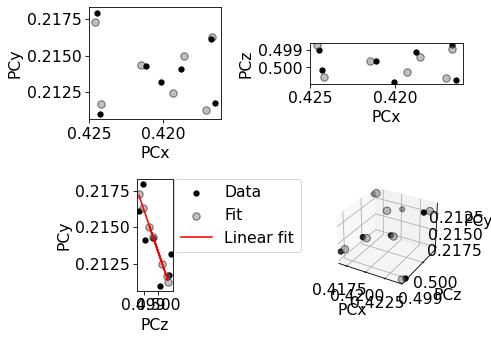

In [26]:
pc_indices = omd.calibration_patterns.indices_scaled.copy()
pc_indices -= omd.roi.origin_scaled
pc_indices = pc_indices.T

det_cal_fit = det_cal_ref.fit_pc(
    pc_indices,
    map_indices=np.indices(s.axes_manager.navigation_shape[::-1]),
    transformation="affine",
)
print(det_cal_fit.pc_average)

# Sample tilt
print(det_cal_fit.sample_tilt)

# Max. deviation between experimental and fitted PC
pc_diff_fit = det_cal_ref.pc - det_cal_fit.pc[tuple(pc_indices)]
print(abs(pc_diff_fit.reshape(-1, 3)).mean(axis=0))

Check the plane of PCs

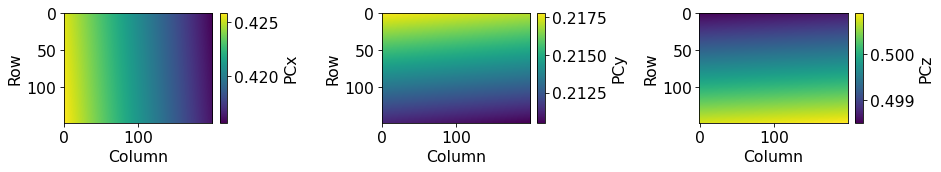

In [27]:
det_cal_fit.plot_pc()

As a final validation of this plane of PCs, we will refine the (refined) orientations using a fixed PC for each pattern, taken from the plane of PCs

In [28]:
det_cal_fit2 = det_cal_fit.deepcopy()
det_cal_fit2.pc = det_cal_fit2.pc[tuple(pc_indices)]

In [29]:
xmap_cal_ref2 = s_cal.refine_orientation(
    xmap=xmap_cal_ref,
    detector=det_cal_fit2,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[10, 10, 10],
    rtol=1e-5,
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [10 10 10]
  Relative tolerance: 1e-05
Refining 7 orientation(s):
[########################################] | 100% Completed | 1.58 sms
Refinement speed: 4.40910 patterns/s


In [30]:
print(xmap_cal_ref2.scores.mean())
print(xmap_cal_ref2.num_evals.mean())

0.4631829134055546
79.57142857142857


In [31]:
angles_cal2 = xmap_cal_ref.orientations.angle_with(
    xmap_cal_ref2.orientations, degrees=True
)
print(angles_cal2)

[1.24664221 1.16340852 1.32758116 1.31727843 1.20195106 1.26532233
 1.17477728]


Get geometrical simulations and add a third set of lines (in blue) to the existing figure

In [32]:
sim_cal_ref2 = simulator.on_detector(det_cal_fit2, xmap_cal_ref2.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 106.12 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 106.40 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 106.14 ms


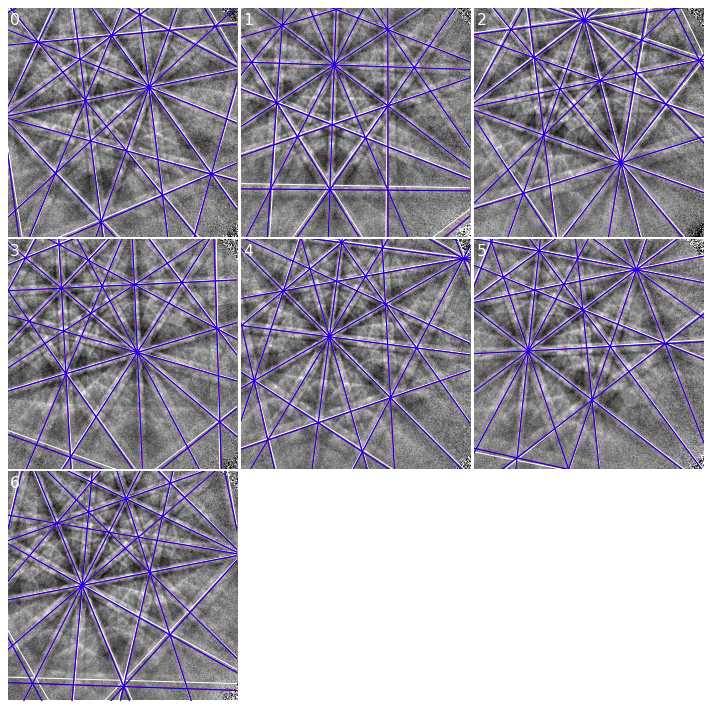

In [33]:
for i in range(xmap_cal_ref2.size):
    lines = sim_cal_ref2.as_collections(i, lines_kwargs=dict(color="b"))[0]
    axes[i].add_collection(lines)
fig

## Hough indexing of all patterns

Now that we are confident of our geometry calibration, we can index all patterns in our noisy experimental dataset.

Copy the detector with the calibrated PCs and update the detector shape to match our experimental patterns

In [34]:
det = det_cal_fit.deepcopy()
det.shape = s.detector.shape
det

EBSDDetector(shape=(60, 60), pc=(0.421, 0.214, 0.5), sample_tilt=71.243, tilt=0.0, azimuthal=0.0, twist=0.0, binning=1.0, px_size=1.0 um)

Get a new indexer

In [35]:
indexer = det.get_indexer(phase_list, g.unique(True), rSigma=2, tSigma=2)

Perform Hough indexing with PyEBSDIndex (using the GPU via PyOpenCL, but only a single CPU)

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker, mean): (0.4208, 0.2142, 0.4997)
  Indexing 29800 pattern(s) in 57 chunk(s)
Radon Time: 0.4510419178986922
Convolution Time: 1.2918679997092113
Peak ID Time: 1.247797625255771
Band Label Time: 1.6367096289759502
Total Band Find Time: 4.6371448340360075
Band Vote Time:  2.952915416099131
  Indexing speed: 3904.85993 patterns/s


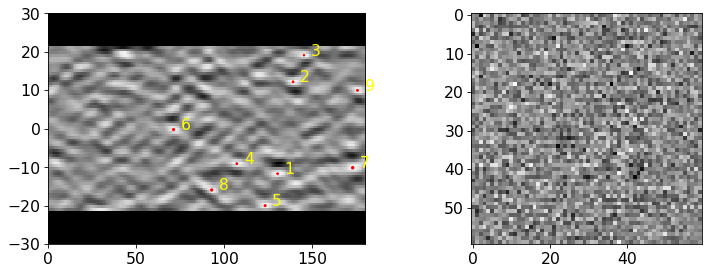

In [36]:
xmap_hi = s.hough_indexing(phase_list=phase_list, indexer=indexer, verbose=2)

Our use of PyEBSDIndex here (with PyOpenCL installed) index about 4 000 patterns/s.

<div class="alert alert-info">

Note

Note that PyEBSDIndex can index a lot faster than this by using more CPUs and by passing a file directly (not via NumPy or Dask arrays, as done here) to its indexing functions.
See its documentation for details: https://pyebsdindex.readthedocs.io/en/latest.

</div>

In [37]:
xmap_hi

Phase    Orientations         Name  Space group  Point group  Proper point group     Color
   -1     1123 (3.8%)  not_indexed         None         None                None         w
    0   28677 (96.2%)           ni        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm, pq, nmatch
Scan unit: um

In [38]:
# Save HI map
# from orix import io
# io.save("xmap_hi.ang", xmap_hi)
# io.save("xmap_hi.h5", xmap_hi)

PyEBSDIndex could not index some 4% of patterns (too high pattern fit).
Let's check the quality metrics (pattern fit, confidence metric, pattern quality, and the number of detected bands that were assigned an index ["indexed"])

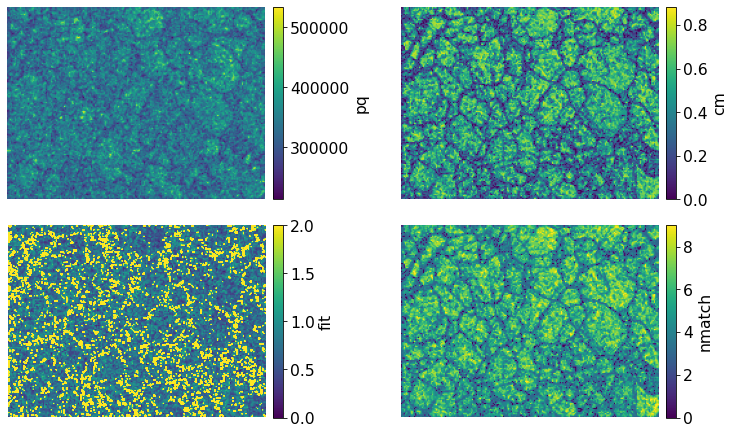

In [39]:
aspect_ratio = xmap_hi.shape[1] / xmap_hi.shape[0]
figsize = (8 * aspect_ratio, 4.5 * aspect_ratio)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, layout="tight")
for ax, to_plot in zip(axes.ravel(), ["pq", "cm", "fit", "nmatch"]):
    if to_plot == "fit":
        im = ax.imshow(xmap_hi.get_map_data(to_plot), vmin=0, vmax=2)
    else:
        im = ax.imshow(xmap_hi.get_map_data(to_plot))
    fig.colorbar(im, ax=ax, label=to_plot, pad=0.02)
    ax.axis("off")

The bright points in the lower left pattern fit map are the points considered not indexed.
The confidence metric and number of successfully labeled bands (out of nine) seem to be highest within grains and lowest at grain boundaries.
Let's inspect the spatial variation of "successfully" indexed orientations in an inverse pole figure map (IPF-X)

In [40]:
pg = xmap_hi.phases[0].point_group
ckey = plot.IPFColorKeyTSL(pg, Vector3d([1, 0, 0]))
ckey

IPFColorKeyTSL, symmetry: m-3m, direction: [1 0 0]

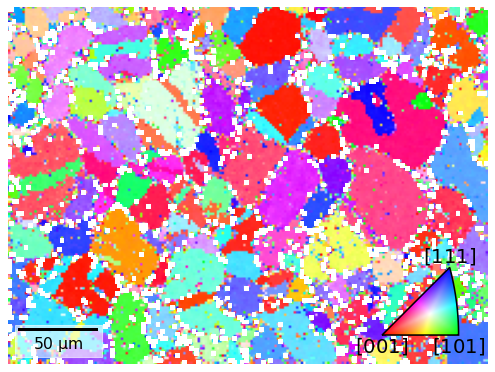

In [41]:
rgb_hi = ckey.orientation2color(xmap_hi["indexed"].rotations)
fig = xmap_hi["indexed"].plot(
    rgb_hi, remove_padding=True, return_figure=True
)

# Place color key in bottom right corner, coordinates are
# [left, bottom, width, height]
ax_ckey = fig.add_axes([0.76, 0.08, 0.2, 0.2], projection="ipf", symmetry=pg)
ax_ckey.plot_ipf_color_key(show_title=False)
ax_ckey.patch.set_facecolor("None")

Many points seen as single color deviations from otherwise smooth colors within recrystallized grains are located mostly at grain boundaries.

## Identify points for re-indexing

Let's see if we can easily separate the good from bad points using any of the quality metrics

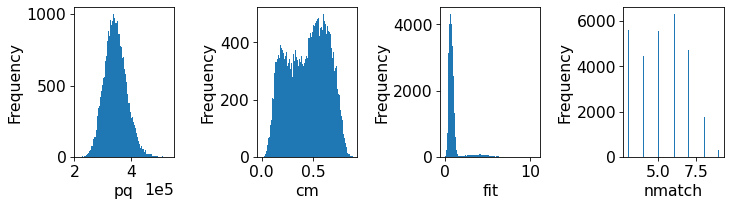

In [42]:
fig, axes = plt.subplots(ncols=4, figsize=(10, 3), layout="tight")
for ax, to_plot in zip(axes.ravel(), ["pq", "cm", "fit", "nmatch"]):
    _ = ax.hist(xmap_hi["indexed"].prop[to_plot], bins=100)
    ax.set(xlabel=to_plot, ylabel="Frequency")
    if to_plot == "pq":
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

... hm, there is no clear bimodal distribution in any of the histograms except perhaps the pattern misfit.
In such cases, one solution is to find the "good" and "bad" points by trial-and-error until a desired separation is achieved.
Here, we have combined metrics by trial-and-error to get a plausible separation.
Note that other combinations might be better for other datasets.

Fraction to re-index: 44.77%


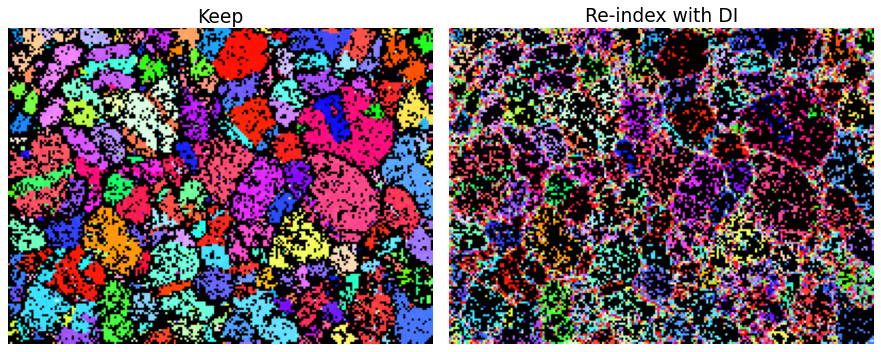

In [43]:
mask_reindex = np.logical_or.reduce(
    (
        ~xmap_hi.is_indexed,
        xmap_hi.fit > 0.95,
        xmap_hi.nmatch < 4,
        xmap_hi.cm < 0.25,
    )
)
frac_reindex = mask_reindex.sum() / mask_reindex.size
print(f"Fraction to re-index: {100 * frac_reindex:.2f}%")

# Get colors for all points, even the ones considered not-indexed
rgb_hi_all = ckey.orientation2color(xmap_hi.rotations)

# Get separate arrays for points to keep and to re-index, with in the other
# array as black
rgb_hi_reindex = np.zeros((xmap_hi.size, 3))
rgb_hi_keep = np.zeros_like(rgb_hi_reindex)
rgb_hi_reindex[mask_reindex] = rgb_hi_all[mask_reindex]
rgb_hi_keep[~mask_reindex] = rgb_hi_all[~mask_reindex]

nav_shape = xmap_hi.shape + (3,)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5), layout="tight")
ax0.imshow(rgb_hi_keep.reshape(nav_shape))
ax1.imshow(rgb_hi_reindex.reshape(nav_shape))
for ax, title in zip([ax0, ax1], ["Keep", "Re-index with DI"]):
    ax.axis("off")
    ax.set(title=title)

There are some spurious points still left among the points to keep.
Otherwise, the inverse pole figure map looks fairly convincing.

Make a 2D navigation mask where points to re-index are set to `False`.

In [44]:
nav_mask = np.ones(xmap_hi.size, dtype=bool)
nav_mask[mask_reindex] = False
nav_mask = nav_mask.reshape(xmap_hi.shape)

## Re-indexing with dictionary indexing

To generate the dictionary of nickel patterns, we need to sample orientation space at a sufficiently high resolution (here 2$^{\circ}$) with a fixed calibration geometry (PC).
See the [pattern matching tutorial](pattern_matching.ipynb) for details.

In [45]:
R = sampling.get_sample_fundamental(resolution=2, point_group=pg)
R

Rotation (100347,)
[[ 0.8541 -0.3536 -0.3536 -0.1435]
 [ 0.8541 -0.3536 -0.3536  0.1435]
 [ 0.8541 -0.3536 -0.1435 -0.3536]
 ...
 [ 0.8541  0.3536  0.1435  0.3536]
 [ 0.8541  0.3536  0.3536 -0.1435]
 [ 0.8541  0.3536  0.3536  0.1435]]

In [46]:
det_pc1 = det.deepcopy()
det_pc1.pc = det_pc1.pc_average

det_pc1.pc

array([[0.42075511, 0.21415109, 0.4997047 ]])

In [47]:
sim = mp.get_patterns(
    rotations=R,
    detector=det_pc1,
    energy=20,
    chunk_shape=R.size // 20,
)
sim

<LazyEBSD, title: , dimensions: (100347|60, 60)>

We only match the intensities within a circular mask (note the inversion!)

In [48]:
signal_mask = kp.filters.Window("circular", det.shape).astype(bool)
signal_mask = ~signal_mask

Perform dictionary indexing of the patterns and intensities marked as `False` in the navigation and signal masks

In [49]:
xmap_di = s.dictionary_indexing(
    sim,
    keep_n=1,
    navigation_mask=nav_mask,
    signal_mask=signal_mask,
)

Dictionary indexing information:
  Phase name: ni
  Matching 13342/29800 experimental pattern(s) to 100347 dictionary pattern(s)
  NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: False, navigation mask: True, signal mask: True


100%|███████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.32s/it]


  Indexing speed: 481.31298 patterns/s, 48298313.36779 comparisons/s


In [50]:
# Save DI map
# io.save("xmap_di.h5", xmap_di)

We see that HI is > 10x faster than DI.

In [51]:
xmap_di.scores.mean()

np.float32(0.16289073)

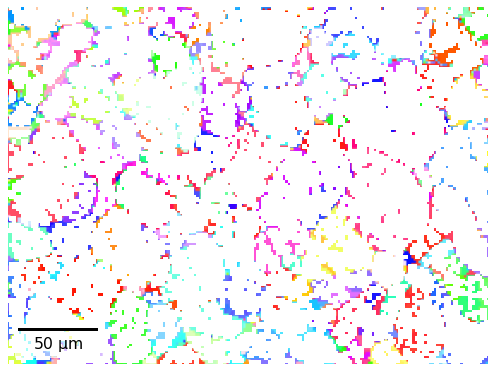

In [52]:
rgb_di = ckey.orientation2color(xmap_di.rotations)
xmap_di.plot(rgb_di, remove_padding=True)

An average correlation score of about 0.15 is low but OK, since we can refine the solutions and would expect a higher score from this.
The IPF-Z map looks plausible, though, which it did not from these patterns after HI.

## Refine Hough indexed and dictionary indexed points

First we specify common refinement parameters, so that the scores obtain can be compared.
This is *very* important!

In [53]:
ref_kw = {
    "detector": det,
    "master_pattern": mp,
    "energy": 20,
    "signal_mask": signal_mask,
    "method": "LN_NELDERMEAD",
    "trust_region": [5, 5, 5],
}

Of the Hough indexed solutions, we only want to refine those that are not re-indexed using dictionary indexing.
We therefore pass the navigation mask, but have to take care to set those points that we want to index to `False`

In [54]:
xmap_hi_ref = s.refine_orientation(
    xmap_hi, navigation_mask=~nav_mask, **ref_kw
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 0.0001
Refining 16458 orientation(s):
[########################################] | 100% Completed | 25.52 ss
Refinement speed: 643.51692 patterns/s


In [55]:
print(xmap_hi_ref.scores.mean())
print(xmap_hi_ref.num_evals.max())

0.24453273460575453
142


An average correlation score of about 0.24 is OK.

We now refine the re-indexed points.
No navigation mask is necessary, since the crystal map returned from DI has a mask keeping track of which points are "in the data" via [CrystalMap.is_in_data](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.CrystalMap.html).

In [56]:
xmap_di_ref = s.refine_orientation(xmap_di, **ref_kw)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 0.0001
Refining 13342 orientation(s):
[########################################] | 100% Completed | 21.00 ss
Refinement speed: 631.17068 patterns/s


In [57]:
print(xmap_di_ref.scores.mean())
print(xmap_di_ref.num_evals.max())

0.2043020737398901
216


An average correlation score of about 0.20 is still OK.

## Merge results

We can now merge the results, taking care to pass the navigation mask where each refined map should be considered.
Since only the points not in the refined HI map were indexed with DI, the same mask can be used in both cases.

In [58]:
xmap_ref = kp.indexing.merge_crystal_maps(
    [xmap_hi_ref, xmap_di_ref], navigation_masks=[~nav_mask, nav_mask]
)

In [59]:
xmap_ref

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    0  29800 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, merged_scores
Scan unit: um

We see that we have a complete map for all our points!

In [60]:
# Save final refined combined map
# io.save("xmap_ref.ang", xmap_ref)
# io.save("xmap_ref.h5", xmap_ref)

## Validate indexing results

Finally, we can compare the IPF-X maps with HI only and after re-indexing, refinement and combination

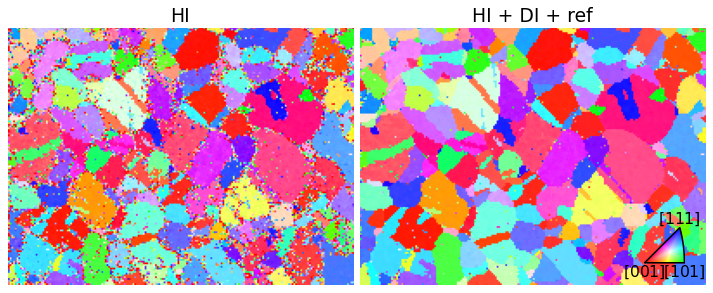

In [61]:
rgb_ref = ckey.orientation2color(xmap_ref.orientations)
rgb_shape = xmap_ref.shape + (3,)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
ax0.imshow(rgb_hi_all.reshape(rgb_shape))
ax1.imshow(rgb_ref.reshape(rgb_shape))
for ax, title in zip([ax0, ax1], ["HI", "HI + DI + ref"]):
    ax.axis("off")
    ax.set(title=title)

ax_ckey = fig.add_axes(
    [0.805, 0.21, 0.1, 0.1], projection="ipf", symmetry=pg
)
ax_ckey.plot_ipf_color_key(show_title=False)
ax_ckey.patch.set_facecolor("None")
_ = [t.set_fontsize(15) for t in ax_ckey.texts]

fig.subplots_adjust(wspace=0.02)

We extract a grid of patterns and plot the geometrical simulations on top of these patterns

In [62]:
s.xmap = xmap_ref
s.detector = det

In [63]:
grid_shape = (4, 4)
s_grid, idx = s.extract_grid(grid_shape, return_indices=True)

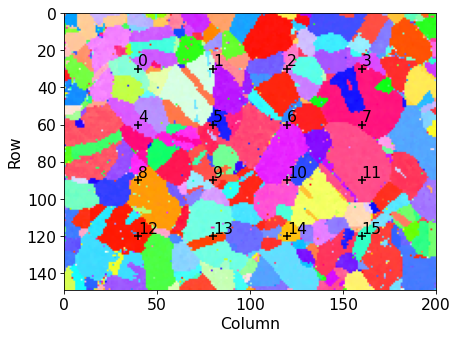

In [64]:
kp.draw.plot_pattern_positions_in_map(
    rc=idx.reshape((2, -1)).T,
    roi_shape=xmap_ref.shape,
    roi_image=rgb_ref.reshape(rgb_shape),
)

In [65]:
sim_grid = simulator.on_detector(
    s_grid.detector, s_grid.xmap.rotations.reshape(*grid_shape)
)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 105.59 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 105.93 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 106.87 ms


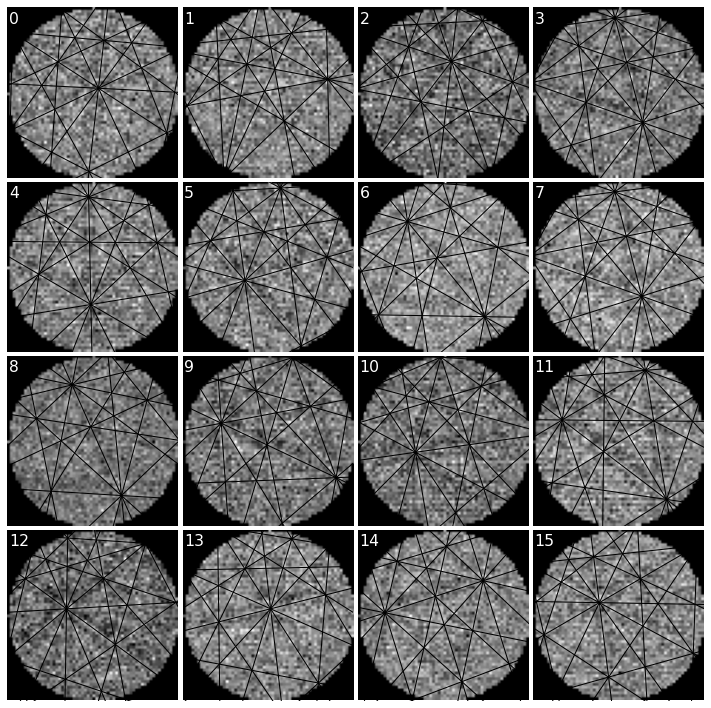

In [66]:
fig, axes = plt.subplots(
    nrows=grid_shape[0], ncols=grid_shape[1], figsize=(12, 12)
)
for idx in np.ndindex(grid_shape):
    ax = axes[idx]
    ax.imshow(s_grid.data[idx] * ~signal_mask, cmap="gray")
    lines = sim_grid.as_collections(idx, lines_kwargs=dict(color="k"))[0]
    ax.add_collection(lines)
    ax.axis("off")
    ax.text(
        0,
        1,
        np.ravel_multi_index(idx, grid_shape),
        va="top",
        ha="left",
        c="w",
    )
fig.subplots_adjust(wspace=0.02, hspace=0.02)

It's difficult to see any bands in these *very* noisy patterns...
There at least seems to be a correlation between darker regions in the patterns (not the corners) and zone axes, which is expected.

In conclusion, by combining the speed of Hough indexing with the robustness towards noise of dictionary indexing, a dataset can be indexed in a shorter time and achieve about the same results as with DI (and refinement) only.

## What's next?

Can we improve indexing results by improving further the signal-to-noise ratio in our very noisy EBSD patterns?
Instead of the "naive" Gaussian kernel used in neighbour pattern averaging, we could try out a more sophisticated kernel with non-local pattern averaging (NLPAR) from `PyEBSDIndex`.
More details are found in their [NLPAR tutorial](https://pyebsdindex.readthedocs.io/en/stable/tutorials/NLPAR_demo.html).